## Performance Python

Import relevant libraries

In [1]:
# numpy is the 'Numerical Python' package
import numpy as np

# Numpy's methods for pseudorandom number generation
import numpy.random as rnd

# For plotting
import matplotlib.pyplot as plt

# scipy is the 'Scientific Python' package
# We'll use the stats package to get some p.d.f.s.
from scipy import stats

%config InlineBackend.figure_format = 'retina'

## Sampling a Laplace distribution with MCMC

$$ X \sim \mathsf{Laplace}(\mu, \lambda) \quad \Rightarrow \quad f_X(x) = \frac{1}{2\lambda} \exp \,\Bigl\{ \frac{| x - \mu | }{\lambda} \Bigr\} \,. $$

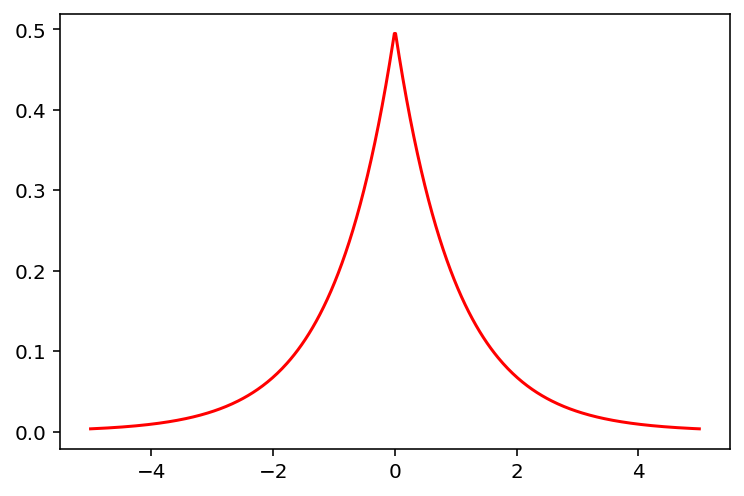

In [2]:
xs = np.linspace(-5,5, 500)
plt.plot(xs, stats.laplace.pdf(xs), 'r');

In [3]:
def sample(R):
    rng = rnd.default_rng(1)

    π = stats.laplace.pdf 
    
    X = np.empty(R)
    X[0] = 0
    
    for n in range(1, R):
        Y = X[n-1] + rng.normal()

        α = π(Y) / π(X[n-1])

        if rng.uniform() < α:
            X[n] = Y
        else:
            X[n] = X[n-1]
    
    return X

### Measure the problem

Before timing any code, put turn off battery saver modes. 

In [4]:
%time X = sample(10**2)

Wall time: 26.5 ms


In [5]:
26.5 / 1000 * 100

2.65

In [6]:
%time X = sample(10**4)

Wall time: 1.68 s


In [7]:
1.68 * 100 / 60

2.8

In [8]:
%timeit X = sample(1)

29.4 µs ± 727 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%load_ext line_profiler

In [10]:
%lprun -f sample sample(10**4)

Timer unit: 1e-07 s

Total time: 2.88904 s
File: <ipython-input-3-0ab92f3542ac>
Function: sample at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def sample(R):
     2         1       1618.0   1618.0      0.0      rng = rnd.default_rng(1)
     3                                           
     4         1         30.0     30.0      0.0      π = stats.laplace.pdf 
     5                                               
     6         1         66.0     66.0      0.0      X = np.empty(R)
     7         1         15.0     15.0      0.0      X[0] = 0
     8                                               
     9     10000      42983.0      4.3      0.1      for n in range(1, R):
    10      9999     406224.0     40.6      1.4          Y = X[n-1] + rng.normal()
    11                                           
    12      9999   27920074.0   2792.3     96.6          α = π(Y) / π(X[n-1])
    13                              

In [11]:
%lprun -f stats.laplace.pdf sample(10**4)

Timer unit: 1e-07 s

Total time: 2.79672 s
File: C:\Users\patri\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py
Function: pdf at line 1714

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1714                                               def pdf(self, x, *args, **kwds):
  1715                                                   """
  1716                                                   Probability density function at x of the given RV.
  1717                                           
  1718                                                   Parameters
  1719                                                   ----------
  1720                                                   x : array_like
  1721                                                       quantiles
  1722                                                   arg1, arg2, arg3,... : array_like
  1723                                                       The shape parameter(s) for the distribution 

In [12]:
%load_ext heat

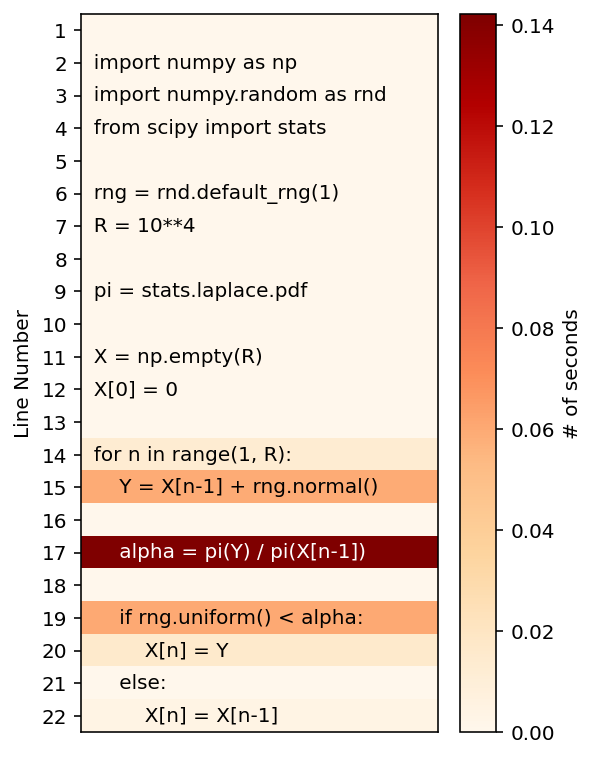

In [13]:
%%heat 

import numpy as np
import numpy.random as rnd
from scipy import stats

rng = rnd.default_rng(1)
R = 10**4

pi = stats.laplace.pdf 

X = np.empty(R)
X[0] = 0

for n in range(1, R):
    Y = X[n-1] + rng.normal()

    alpha = pi(Y) / pi(X[n-1])

    if rng.uniform() < alpha:
        X[n] = Y
    else:
        X[n] = X[n-1]


In [14]:
%load_ext snakeviz

In [15]:
%snakeviz X = sample(10**4)

 
*** Profile stats marshalled to file 'C:\\Users\\patri\\AppData\\Local\\Temp\\tmpn9il9v6r'. 
Embedding SnakeViz in this document...


### Check improvements one-by-one

#### Replace built-in Laplace p.d.f. with a version we have made.

In [16]:
xs = np.linspace(-5, 5, 11)
old = stats.laplace.pdf(xs)
new = np.exp(-np.abs(xs))/2 
old - new

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
xs = np.linspace(-5, 5, 10**5)
%timeit stats.laplace.pdf(xs)
%timeit np.exp(-np.abs(xs))  # Don't need normalising constant

5.58 ms ± 315 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.2 ms ± 35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
5.58 / 1.2

4.65

In [19]:
xs = np.linspace(-5, 5, 10**5)
%timeit [stats.laplace.pdf(x) for x in xs]
%timeit [np.exp(-np.abs(x)) for x in xs]

7.37 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
233 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
7.37 / 0.233 

31.630901287553648

In [21]:
samplePrev = sample

In [22]:
def sample(R):
    rng = rnd.default_rng(1)

    π = lambda x: np.exp(-np.abs(x))
    
    X = np.empty(R)
    X[0] = 0
    
    for n in range(1, R):
        Y = X[n-1] + rng.normal()

        α = π(Y) / π(X[n-1])

        if rng.uniform() < α:
            X[n] = Y
        else:
            X[n] = X[n-1]
    
    return X

In [23]:
print(samplePrev(5))
print(sample(5))

[ 0.          0.          0.          0.         -0.53695324]
[ 0.          0.          0.          0.         -0.53695324]


In [24]:
%time X = samplePrev(10**5)
%time X = sample(10**5)

Wall time: 16.3 s
Wall time: 987 ms


In [25]:
16.3 / 0.987

16.51469098277609

In [26]:
%lprun -f sample sample(10**5)

Timer unit: 1e-07 s

Total time: 1.38244 s
File: <ipython-input-22-2f3c9d85c13d>
Function: sample at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def sample(R):
     2         1       1803.0   1803.0      0.0      rng = rnd.default_rng(1)
     3                                           
     4         1         10.0     10.0      0.0      π = lambda x: np.exp(-np.abs(x))
     5                                               
     6         1        160.0    160.0      0.0      X = np.empty(R)
     7         1         15.0     15.0      0.0      X[0] = 0
     8                                               
     9    100000     425389.0      4.3      3.1      for n in range(1, R):
    10     99999    3331726.0     33.3     24.1          Y = X[n-1] + rng.normal()
    11                                           
    12     99999    6631665.0     66.3     48.0          α = π(Y) / π(X[n-1])
    13                   

#### Let's try vectorising the random number generation

In [27]:
samplePrev = sample

In [28]:
def sample(R):
    rng = rnd.default_rng(1)

    π = lambda x: np.exp(-np.abs(x))

    X = np.empty(R)
    X[0] = 0

    jumps = rng.normal(size=R-1)
    uniforms = rng.uniform(size=R-1)

    for n in range(1, R):
        Y = X[n-1] + jumps[n-1]

        α = π(Y) / π(X[n-1])

        if uniforms[n-1] < α:
            X[n] = Y
        else:
            X[n] = X[n-1]
    
    return X

In [29]:
print(samplePrev(5))
print(sample(5))

[ 0.          0.          0.          0.         -0.53695324]
[ 0.          0.34558419  1.16720234  1.16720234 -0.1359549 ]


In [30]:
%time X = samplePrev(10**6)
%time X = sample(10**6)

Wall time: 9.98 s
Wall time: 6.14 s


In [31]:
9.98 / 6.14

1.6254071661237786

In [32]:
%lprun -f sample sample(10**6)

Timer unit: 1e-07 s

Total time: 9.0506 s
File: <ipython-input-28-f0fc8c08d600>
Function: sample at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def sample(R):
     2         1       1906.0   1906.0      0.0      rng = rnd.default_rng(1)
     3                                           
     4         1         21.0     21.0      0.0      π = lambda x: np.exp(-np.abs(x))
     5                                           
     6         1        406.0    406.0      0.0      X = np.empty(R)
     7         1         21.0     21.0      0.0      X[0] = 0
     8                                           
     9         1     224605.0 224605.0      0.2      jumps = rng.normal(size=R-1)
    10         1     109040.0 109040.0      0.1      uniforms = rng.uniform(size=R-1)
    11                                           
    12   1000000    4178819.0      4.2      4.6      for n in range(1, R):
    13    999999    9092839

#### Let's try getting rid of the exponential in the p.d.f.

In [33]:
samplePrev = sample

In [34]:
def sample(R):
    rng = rnd.default_rng(1)

    logπ = lambda x: -np.abs(x)

    X = np.empty(R)
    X[0] = 0

    jumps = rng.normal(size=R-1)
    exponentials = np.log(rng.uniform(size=R-1)) # Seems faster than rng.exponential

    for n in range(1, R):
        Y = X[n-1] + jumps[n-1]

        logα = logπ(Y) - logπ(X[n-1])

        if exponentials[n-1] < logα:
            X[n] = Y
        else:
            X[n] = X[n-1]
    
    return X

In [35]:
print(samplePrev(5))
print(sample(5))

[ 0.          0.34558419  1.16720234  1.16720234 -0.1359549 ]
[ 0.          0.34558419  1.16720234  1.16720234 -0.1359549 ]


In [36]:
%time X = samplePrev(10**6)
%time X = sample(10**6)

Wall time: 6.06 s
Wall time: 3.5 s


In [37]:
6.06 / 3.5

1.7314285714285713

### Sample from a truncated Laplace distribution

In [38]:
def sample(R):
    rng = rnd.default_rng(1)

    π = lambda x: (x > -1) * (x < 1) * np.exp(-np.abs(x))

    X = np.empty(R)
    X[0] = 0

    jumps = rng.normal(size=R-1)
    uniforms = rng.uniform(size=R-1)

    for n in range(1, R):
        Y = X[n-1] + jumps[n-1]

        α = π(Y) / π(X[n-1])

        if uniforms[n-1] < α:
            X[n] = Y
        else:
            X[n] = X[n-1]
    
    return X

Wall time: 1.45 s


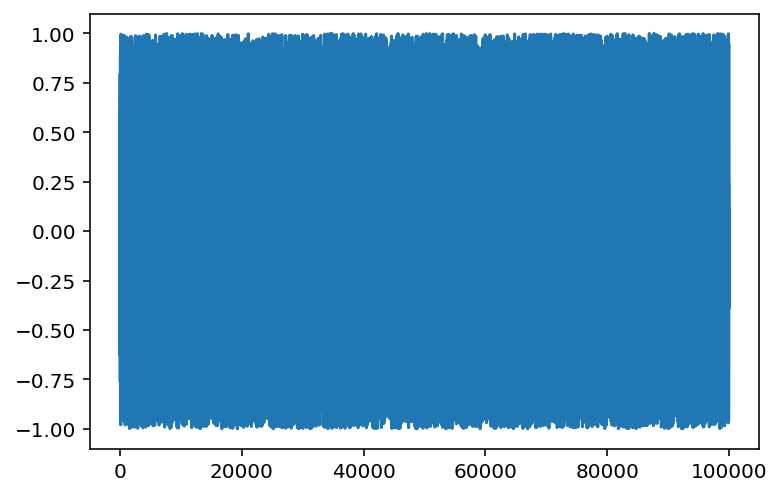

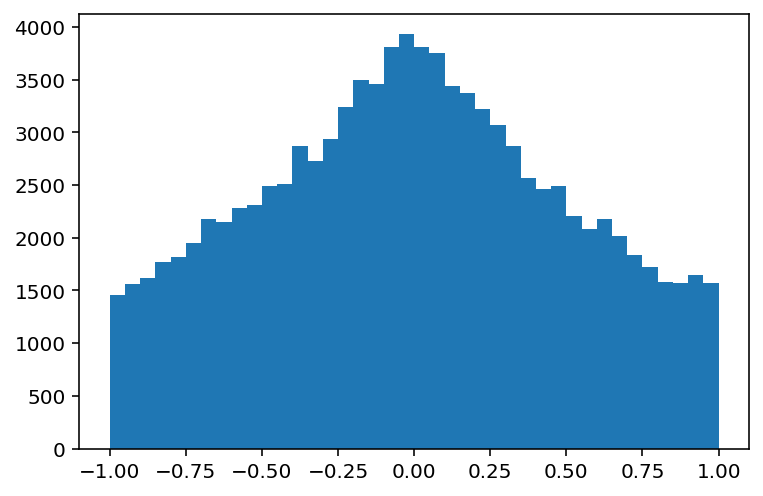

In [39]:
%time X = sample(10**5)

plt.plot(X)
plt.show()

plt.hist(X, 40);

In [40]:
np.mean(np.diff(X) == 0)

0.4680446804468045

In [41]:
samplePrev = sample

In [42]:
def sample(R):
    rng = rnd.default_rng(1)

    πUn = lambda x: np.exp(-np.abs(x))

    X = np.empty(R)
    X[0] = 0

    jumps = rng.normal(size=R-1)
    uniforms = rng.uniform(size=R-1)

    for n in range(1, R):
        Y = X[n-1] + jumps[n-1]
        
        # Check the constraint first
        if Y <= -1 or Y >= 1:
            X[n] = X[n-1]
            continue

        # Then, if a valid proposal,
        # calculate the acceptance prob.
        α = πUn(Y) / πUn(X[n-1])

        if uniforms[n-1] < α:
            X[n] = Y
        else:
            X[n] = X[n-1]

    return X

In [43]:
print(samplePrev(5))
print(sample(5))

[ 0.          0.34558419  0.34558419  0.34558419 -0.95757304]
[ 0.          0.34558419  0.34558419  0.34558419 -0.95757304]


In [44]:
%time X = samplePrev(10**6)
%time X = sample(10**6)

Wall time: 14.6 s
Wall time: 4.11 s


In [45]:
14.6 / 4.11

3.552311435523114

### Try compiling the algorithm with numba

In [46]:
from numba import njit

In [47]:
samplePrev = sample

In [48]:
@njit
def sample(R):
    rng = rnd.default_rng(1)

    πUn = lambda x: np.exp(-np.abs(x))

    X = np.empty(R)
    X[0] = 0

    jumps = rng.normal(size=R-1)
    uniforms = rng.uniform(size=R-1)

    for n in range(1, R):
        Y = X[n-1] + jumps[n-1]
        
        # Check the constraint first
        if Y <= -1 or Y >= 1:
            X[n] = X[n-1]
            continue

        # Then, if a valid proposal,
        # calculate the acceptance prob.
        α = πUn(Y) / πUn(X[n-1])

        if uniforms[n-1] < α:
            X[n] = Y
        else:
            X[n] = X[n-1]

    return X

In [49]:
sample(5)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'default_rng' of type Module(<module 'numpy.random' from 'C:\\Users\\patri\\Anaconda3\\lib\\site-packages\\numpy\\random\\__init__.py'>)
[1m
File "<ipython-input-48-bced36de9aed>", line 3:[0m
[1mdef sample(R):
[1m    rng = rnd.default_rng(1)
[0m    [1m^[0m[0m
[0m
[0m[1m[1] During: typing of get attribute at <ipython-input-48-bced36de9aed> (3)[0m
[1m
File "<ipython-input-48-bced36de9aed>", line 3:[0m
[1mdef sample(R):
[1m    rng = rnd.default_rng(1)
[0m    [1m^[0m[0m


In [50]:
def sample(R):
    rng = rnd.default_rng(1)

    X = np.empty(R)
    X[0] = 0

    jumps = rng.normal(size=R-1)
    uniforms = rng.uniform(size=R-1)

    sample_jit(X, jumps, uniforms)

    return X

@njit
def sample_jit(X, jumps, uniforms):
    R = len(X)
    
    πUn = lambda x: np.exp(-np.abs(x))
    
    for n in range(1, R):
        Y = X[n-1] + jumps[n-1]
        
        # Check the constraint first
        if Y <= -1 or Y >= 1:
            X[n] = X[n-1]
            continue

        # Then, if a valid proposal,
        # calculate the acceptance prob.
        α = πUn(Y) / πUn(X[n-1])

        if uniforms[n-1] < α:
            X[n] = Y
        else:
            X[n] = X[n-1]

In [51]:
%time X = sample(10**6)
%time X = sample(10**6)

Wall time: 242 ms
Wall time: 41 ms


In [52]:
print(samplePrev(5))
print(sample(5))

[ 0.          0.34558419  0.34558419  0.34558419 -0.95757304]
[ 0.          0.34558419  0.34558419  0.34558419 -0.95757304]


In [53]:
%time X = samplePrev(10**6)
%time X = sample(10**6)

Wall time: 4.67 s
Wall time: 41.9 ms


In [54]:
4.67 / 0.0419

111.45584725536993

In [55]:
from numba import int64, float64

In [56]:
samplePrev = sample

In [57]:
@njit(float64[:](int64))
def sample(R):
    rnd.seed(123)
    X = np.empty(R)
    X[0] = 0
    for n in range(1, R):
        Y = X[n-1] + rnd.normal(0, 1)

        α = (Y > -1) * (Y < 1) * np.exp(-np.abs(Y)+np.abs(X[n-1]))

        if rnd.uniform(0, 1) < α:
            X[n] = Y
        else:
            X[n] = X[n-1]
            
    return X

In [58]:
%time X = sample(10**7)
%time X = sample(10**7)

Wall time: 572 ms
Wall time: 584 ms


In [59]:
%timeit X = samplePrev(10**7)
%timeit X = sample(10**7)

400 ms ± 8.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
578 ms ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


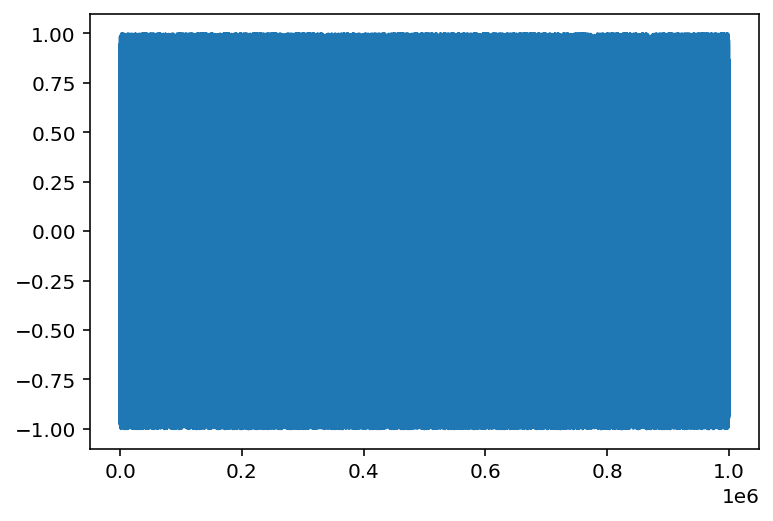

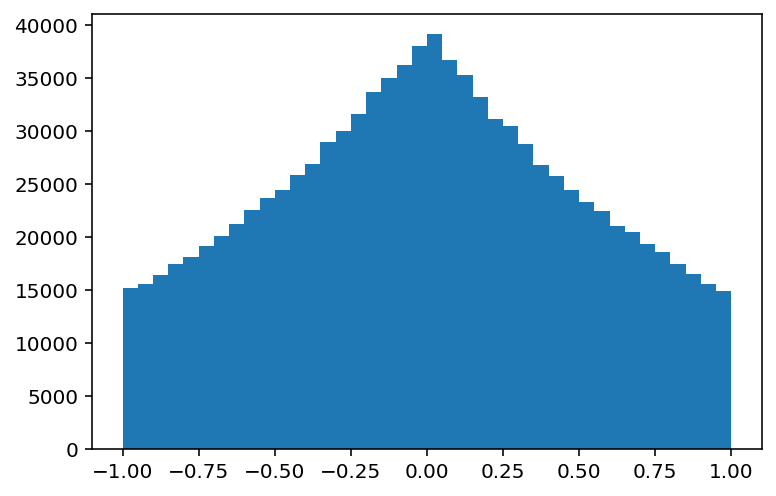

In [60]:
plt.plot(X[:10**6])
plt.show()

plt.hist(X[:10**6], 40);

Can get a little faster by noticing that each `π` function call is called (at least) twice with the same arguments. If the result is stored/cached, then we get faster but uglier code, so I'll stop here. 
Similarly, one can try to [simulate using a truncated proposal](https://darrenjw.wordpress.com/2012/06/04/metropolis-hastings-mcmc-when-the-proposal-and-target-have-differing-support/) so that invalid points are never proposed.

### Keep in mind

Improvements to the algorithm and your choice of hyperparameters are often a better starting point than going down a rabbit-hole of performance optimisations!

Updating Python and its packages may give you a free small speed boost (or maybe it will slow things down). With this numpy update, I tested CMC before and after and the time went from 5m 4s down to 3m 54s.

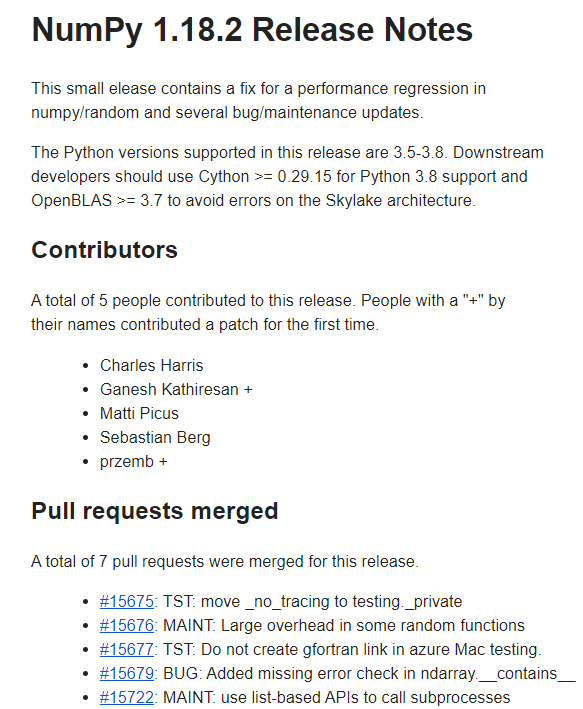

In [61]:
from IPython.display import Image
Image("numpy_update.png")